In [204]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV

import xgboost as xgb
from catboost import CatBoostRegressor, CatBoostClassifier, Pool
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from imblearn.over_sampling import SMOTE

from sklearn.cluster import KMeans
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
data = pd.read_csv('forestfires.csv')

In [3]:
data.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


Регрессия: Предсказать площадь (признак area) на основе остальных признаков. \
Классификация: Классифицировать, был ли пожар значительным или нет.  \
Например, можно установить порог для площади area и классифицировать пожары как "большие" или "маленькие".

Предобработка данных: \
Исследование данных и их типов. \
Проверка на пропущенные значения. \
Визуализация распределения признаков и целевой переменной. \
Кодирование категориальных признаков. \
Нормализация числовых признаков.

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [11]:
data.isnull().sum()

X        0
Y        0
month    0
day      0
FFMC     0
DMC      0
DC       0
ISI      0
temp     0
RH       0
wind     0
rain     0
area     0
dtype: int64

Типы данных: 

X, Y, RH — целые числа (int64). \
month, day — строковые данные (object). \
Остальные признаки — числа с плавающей точкой (float64). \
Пропущенные значения: Пропущенных значений нет.

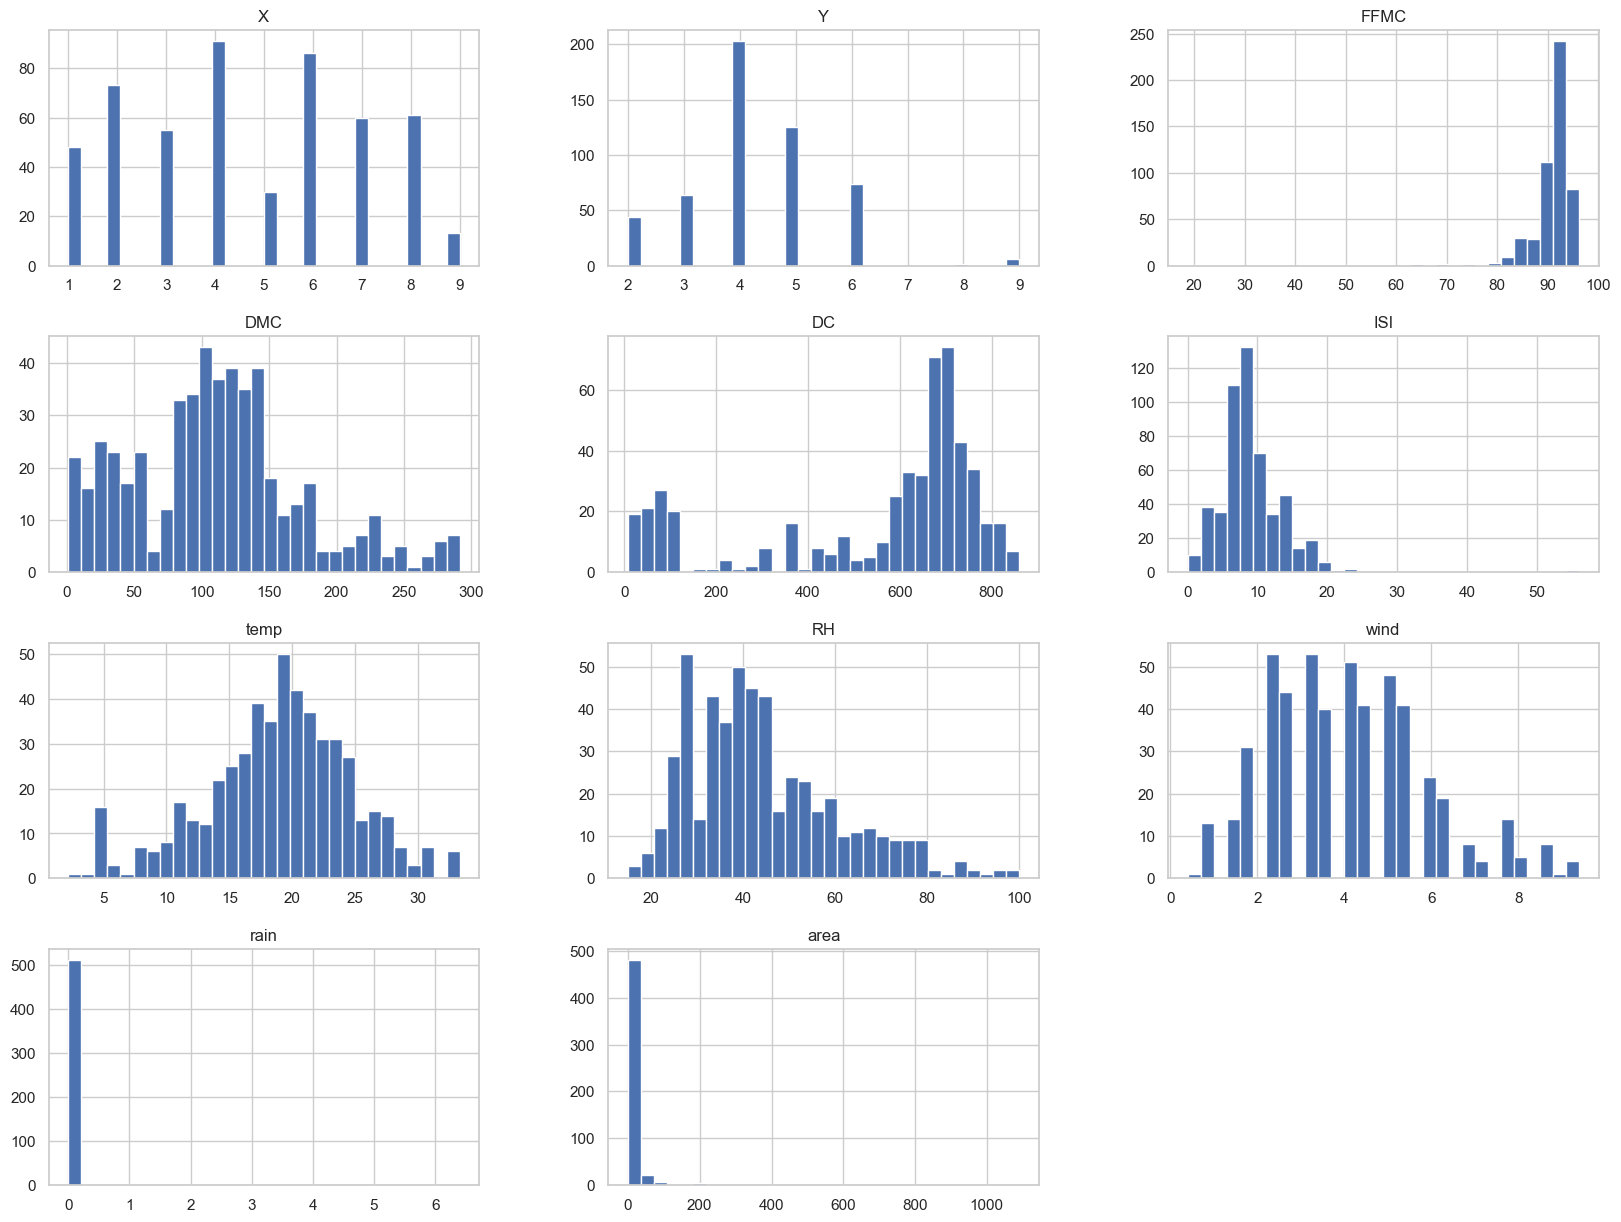

In [16]:
sns.set(style='whitegrid')

data.hist(bins=30,figsize=(20,15))
plt.show()

Визуализация целевой переменной


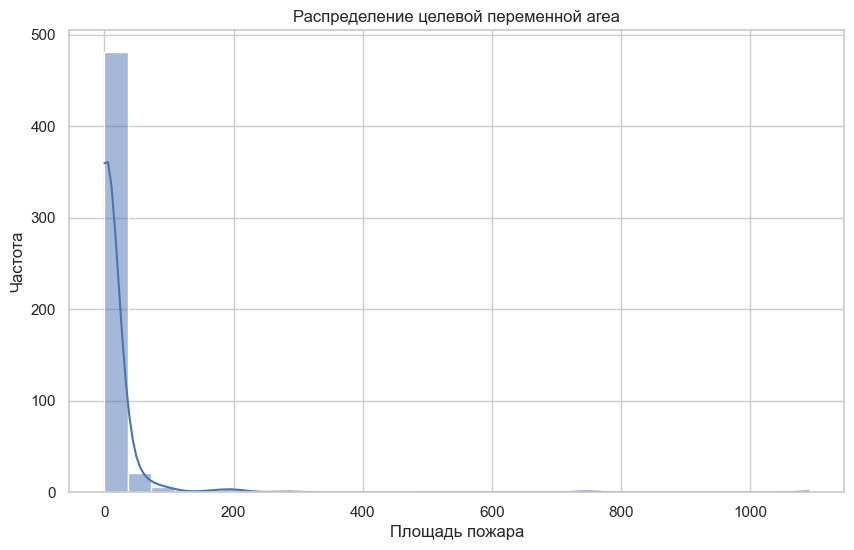

In [17]:
plt.figure(figsize=(10,6))
sns.histplot(data['area'],bins=30,kde=True)
plt.title('Распределение целевой переменной area')
plt.xlabel('Площадь пожара')
plt.ylabel('Частота')
plt.show()

Распределение признаков:

Большинство признаков имеют нормальное или близкое к нормальному распределение. \
Некоторые признаки, такие как rain, имеют сильное смещение (много нулевых значений). \
Распределение целевой переменной (area):

Распределение area сильно смещено влево, большинство значений близки к нулю. \
Это указывает на то, что большинство пожаров охватывают очень маленькую площадь, а большие пожары встречаются редко. \
Предобработка данных \
Кодирование категориальных признаков:

month и day будут закодированы с использованием one-hot encoding. \
Нормализация числовых признаков:

Все числовые признаки будут нормализованы для улучшения производительности моделей.

In [20]:
# Кодирование категориальных признаков
data_encoded = pd.get_dummies(data,columns=['month','day'])

In [22]:
# Нормализация числовых признаков
scaler = StandardScaler()
numerical_features = ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']
data_encoded[numerical_features] = scaler.fit_transform(data_encoded[numerical_features])

In [23]:
# Просмотр первых нескольких строк обработанных данных
data_encoded.head()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,month_nov,month_oct,month_sep,day_fri,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed
0,1.008313,0.569860,-0.805959,-1.323326,-1.830477,-0.860946,-1.842640,0.411724,1.498614,-0.073268,...,False,False,False,True,False,False,False,False,False,False
1,1.008313,-0.244001,-0.008102,-1.179541,0.488891,-0.509688,-0.153278,-0.692456,-1.741756,-0.073268,...,False,True,False,False,False,False,False,False,True,False
2,1.008313,-0.244001,-0.008102,-1.049822,0.560715,-0.509688,-0.739383,-0.692456,-1.518282,-0.073268,...,False,True,False,False,False,True,False,False,False,False
3,1.440925,1.383722,0.191362,-1.212361,-1.898266,-0.004756,-1.825402,3.233519,-0.009834,0.603155,...,False,False,False,True,False,False,False,False,False,False
4,1.440925,1.383722,-0.243833,-0.931043,-1.798600,0.126966,-1.291012,3.356206,-1.238940,-0.073268,...,False,False,False,False,False,False,True,False,False,False


Разделение данных на тренировочный и тестовый наборы. \
Обучение регрессионной модели. \
Оценка модели.

In [25]:
# Разделение на признаки и целевую переменную
X = data_encoded.drop('area',axis=1)
y = data_encoded['area']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [29]:
# Обучение модели
clf = RandomForestRegressor(n_estimators=100,random_state=42)
clf.fit(X_train,y_train)

RandomForestRegressor(random_state=42)

In [30]:
# Предсказание на тестовых данных
y_pred = clf.predict(X_test)

In [31]:
# Оценка модели
mae = mean_absolute_error(y_test,y_pred)
mse = mean_squared_error(y_test,y_pred)
r2 = r2_score(y_test,y_pred)

In [32]:
mae,mse,r2

(26.88719263736264, 12023.1357818574, -0.01996762903230076)

MAE: Средняя абсолютная ошибка предсказаний составляет около 26.89, что выше, чем у линейной регрессии. \
MSE: Средняя квадратичная ошибка также выше, чем у линейной регрессии, что указывает на большие отклонения в предсказаниях. \
R²: Отрицательное значение R² указывает на то, что модель объясняет меньше дисперсии данных, чем простое усреднение.

Гиперпараметрическая настройка: Подбор гиперпараметров модели Random Forest. \
Использование других моделей: Попробовать другие регрессионные модели, такие как Gradient Boosting, XGBoost. \
Feature Engineering: Создание новых признаков или преобразование существующих для улучшения модели.

In [35]:
parametrics = {
    'n_estimators' : [100,200,300],
    'max_depth' : [None,10,20,30],
    'min_samples_split' : [2,5,10],
    'min_samples_leaf' : [1,2,4]
}

In [36]:
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=parametrics,cv=3,n_jobs=-1,verbose=2)
grid_search.fit(X_train,y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [37]:
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test)

In [38]:
# Оценка модели
mae = mean_absolute_error(y_test,y_pred)
mse = mean_squared_error(y_test,y_pred)
r2 = r2_score(y_test,y_pred)

In [39]:
grid_search.best_params_, mae, mse, r2

({'max_depth': None,
  'min_samples_leaf': 4,
  'min_samples_split': 10,
  'n_estimators': 300},
 25.704575743606974,
 11775.082709692426,
 0.0010756419147068819)

MAE указывает на среднюю абсолютную ошибку предсказаний, что означает, что модель ошибается в среднем на 25.70 единиц при предсказании площади пожара. \
MSE показывает, что модель имеет достаточно высокую квадратичную ошибку, что указывает на значительные отклонения. \
R² очень близок к нулю, что говорит о том, что модель почти не объясняет вариацию данных.

Диаграммы размаха (Boxplots). \
Метод Z-оценок. \
Метод IQR (межквартильный размах).

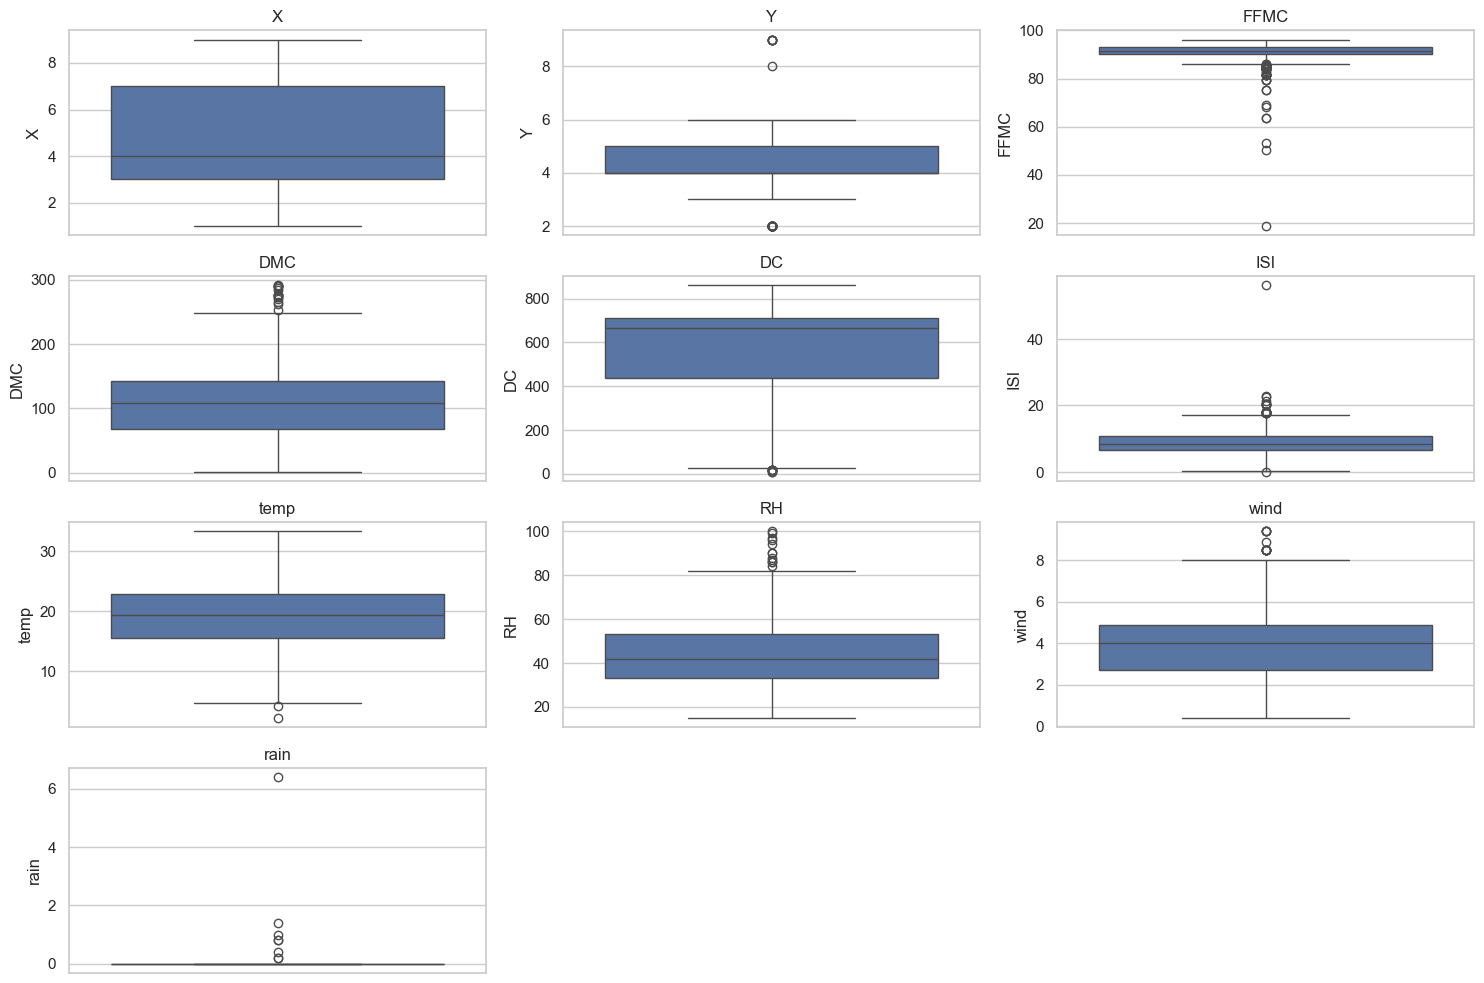

In [41]:
# Построение диаграмм размаха для числовых признаков
plt.figure(figsize=(15, 10))

for i, feature in enumerate(numerical_features):
    plt.subplot(4, 3, i + 1)
    sns.boxplot(data[feature])
    plt.title(feature)

plt.tight_layout()
plt.show()

In [45]:

def detect_outliers_iqr(data):
    outliers = {}
    numerical_features = data.select_dtypes(include=[np.number]).columns.tolist()
    
    for feature in numerical_features:
        Q1 = data[feature].quantile(0.25)
        Q3 = data[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[feature] = data[(data[feature] < lower_bound) | (data[feature] > upper_bound)].shape[0]
    
    return outliers

# Обнаружение выбросов
outliers = detect_outliers_iqr(data)
print(outliers)


{'X': 0, 'Y': 51, 'FFMC': 53, 'DMC': 17, 'DC': 8, 'ISI': 23, 'temp': 2, 'RH': 12, 'wind': 13, 'rain': 8, 'area': 63}


Удаление выбросов: Удаление строк с выбросами. \
Трансформация данных: Применение логарифмической или другой трансформации.

In [46]:
def remove_outliers(data):
    numerical_features = data.select_dtypes(include=[np.number]).columns.tolist()
    
    for feature in numerical_features:
        Q1 = data[feature].quantile(0.25)
        Q3 = data[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        data = data[(data[feature] >= lower_bound) & (data[feature] <= upper_bound)]
    
    return data

# Удаление выбросов
data_cleaned = remove_outliers(data)
print(data_cleaned.shape)


(270, 13)


Переподготовка данных: Кодирование категориальных признаков и нормализация числовых признаков. \
Обучение модели: Повторное обучение модели с использованием нового набора данных. \
Оценка модели: Оценка производительности модели на новых данных.

In [48]:
# Кодирование категориальных признаков
data_encoded_cleaned = pd.get_dummies(data_cleaned, columns=['month', 'day'])

In [50]:
# Нормализация числовых признаков
scaler = StandardScaler()
numerical_features = ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']
data_encoded_cleaned[numerical_features] = scaler.fit_transform(data_encoded_cleaned[numerical_features])

In [52]:
# Разделение на признаки и целевую переменную
X_cleaned = data_encoded_cleaned.drop('area', axis=1)
y_cleaned = data_encoded_cleaned['area']

In [53]:
# Разделение на тренировочный и тестовый наборы
X_train_cleaned, X_test_cleaned, y_train_cleaned, y_test_cleaned = train_test_split(X_cleaned, y_cleaned, test_size=0.2, random_state=42)

In [54]:
# Обучение модели с найденными гиперпараметрами
best_model = RandomForestRegressor(
    max_depth=None,
    min_samples_leaf=4,
    min_samples_split=10,
    n_estimators=300,
    random_state=42
)
best_model.fit(X_train_cleaned, y_train_cleaned)

RandomForestRegressor(min_samples_leaf=4, min_samples_split=10,
                      n_estimators=300, random_state=42)

In [55]:
# Предсказание на тестовых данных
y_pred_cleaned = best_model.predict(X_test_cleaned)

In [56]:
# Оценка модели
mae_cleaned = mean_absolute_error(y_test_cleaned, y_pred_cleaned)
mse_cleaned = mean_squared_error(y_test_cleaned, y_pred_cleaned)
r2_cleaned = r2_score(y_test_cleaned, y_pred_cleaned)

In [57]:
mae_cleaned, mse_cleaned, r2_cleaned

(2.734612791195343, 12.866102063459788, -0.04594787067519901)

MAE: Значительное улучшение, ошибка снизилась до 2.73. \
MSE: Тоже заметное улучшение, значение уменьшилось до 12.87. \
R²: Все еще отрицательное, что говорит о том, что модель не объясняет вариацию данных должным образом.

In [59]:
# Обучение модели Gradient Boosting
clf_gb = GradientBoostingRegressor(n_estimators=100,max_depth=4,min_samples_split=5,min_samples_leaf=4,random_state=42)
clf_gb.fit(X_train_cleaned,y_train_cleaned)

GradientBoostingRegressor(max_depth=4, min_samples_leaf=4, min_samples_split=5,
                          random_state=42)

In [61]:
# Предсказание на тестовых данных
y_pred_gb = clf_gb.predict(X_test_cleaned)

In [62]:
# Оценка модели
mae_gb = mean_absolute_error(y_test_cleaned, y_pred_gb)
mse_gb = mean_squared_error(y_test_cleaned, y_pred_gb)
r2_gb = r2_score(y_test_cleaned, y_pred_gb)

In [63]:
mae_gb,mse_gb,r2_gb

(2.97066787122823, 16.36610088405194, -0.33047975886540093)

In [75]:
# Применение логарифмического преобразования к целевой переменной
y_cleaned = data_cleaned['area']
y_cleaned_log = np.log1p(y_cleaned)

In [78]:
# Кодирование категориальных признаков и нормализация числовых признаков
data_encoded_cleaned = pd.get_dummies(data_cleaned, columns=['month', 'day'])
scaler = StandardScaler()
numerical_features = ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']
data_encoded_cleaned[numerical_features] = scaler.fit_transform(data_encoded_cleaned[numerical_features])

In [79]:
# Разделение на признаки и целевую переменную
X_cleaned = data_encoded_cleaned.drop('area', axis=1)

In [65]:
X_train_cleaned_log, X_test_cleaned_log, y_train_cleaned_log, y_test_cleaned_log = train_test_split(X_cleaned, y_cleaned_log, test_size=0.2, random_state=42)

In [67]:
# Обучение модели Gradient Boosting с логарифмической целевой переменной
clf_gb_log = GradientBoostingRegressor(n_estimators=300,max_depth=4,min_samples_split=5,min_samples_leaf=4,random_state=42)

In [68]:
clf_gb_log.fit(X_train_cleaned_log,y_train_cleaned_log)

GradientBoostingRegressor(max_depth=4, min_samples_leaf=4, min_samples_split=5,
                          n_estimators=300, random_state=42)

In [69]:
y_pred_gb_log = clf_gb_log.predict(X_test_cleaned_log)

In [70]:
y_pred_gb_log_exp = np.expm1(y_pred_gb_log)

In [72]:
mae_gb_log = mean_absolute_error(y_test_cleaned, y_pred_gb_log_exp)
mse_gb_log = mean_squared_error(y_test_cleaned, y_pred_gb_log_exp)
r2_gb_log = r2_score(y_test_cleaned, y_pred_gb_log_exp)

In [82]:
# Построение корреляционной матрицы
corr_matrix = data_encoded_cleaned.corr()

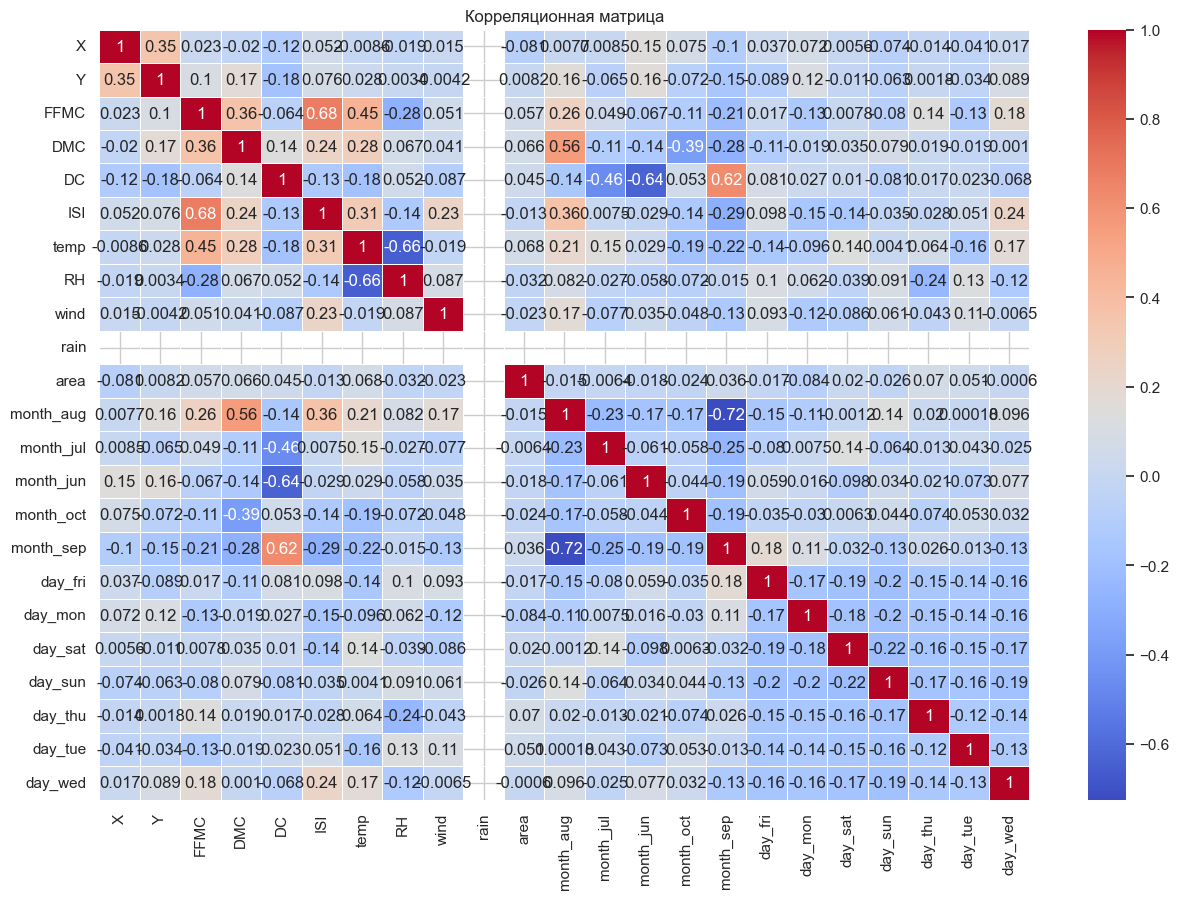

(2.835874245789419, 17.084143368250356, -0.3888529167726924)

In [83]:
# Визуализация корреляционной матрицы
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Корреляционная матрица')
plt.show()

mae_gb_log, mse_gb_log, r2_gb_log

Корреляционная матрица показывает, что некоторые признаки имеют сильную корреляцию друг с другом. \
FFMC, DMC, DC и ISI имеют значительную корреляцию с друг другом, что может указывать на избыточность информации.

In [87]:
# Обучение модели XGBoost
clf_xgb = xgb.XGBRegressor(n_estimators=300, max_depth=4, learning_rate=0.1, random_state=42)
clf_xgb.fit(X_train_cleaned_log, y_train_cleaned_log)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [88]:
y_pred_xgb = clf_xgb.predict(X_test_cleaned_log)

In [92]:
y_pred_xgb_exp = np.expm1(y_pred_xgb)

In [93]:
mae_xgb = mean_absolute_error(y_test_cleaned, y_pred_xgb_exp)
mse_xgb = mean_squared_error(y_test_cleaned, y_pred_xgb_exp)
r2_xgb = r2_score(y_test_cleaned, y_pred_xgb_exp)

In [94]:
mae_xgb, mse_xgb, r2_xgb

(2.936380155936436, 17.09255528301297, -0.3895367621433308)

In [107]:
X_cleaned_reduced = data_reduced.drop('area', axis=1)

In [108]:
X_train_cleaned_reduced_log, X_test_cleaned_reduced_log, y_train_cleaned_reduced_log, y_test_cleaned_reduced_log = train_test_split(X_cleaned_reduced, y_cleaned_log, test_size=0.2, random_state=42)

In [110]:
# Обучение модели CatBoost с логарифмической целевой переменной
clf_cat = CatBoostRegressor(iterations=300, depth=4, learning_rate=0.1, random_state=42, verbose=0)
clf_cat.fit(X_train_cleaned_reduced_log, y_train_cleaned_reduced_log)

In [109]:
y_pred_cat = clf_cat.predict(X_test_cleaned_log)

In [111]:
y_pred_cat_exp = np.expm1(y_pred_cat)

In [112]:
mae_cat = mean_absolute_error(y_test_cleaned, y_pred_cat_exp)
mse_cat = mean_squared_error(y_test_cleaned, y_pred_cat_exp)
r2_cat = r2_score(y_test_cleaned, y_pred_cat_exp)

In [113]:
mae_cat,mse_cat,r2_cat

(2.6802312159469657, 15.598101629976647, -0.2680453727150254)

Попробуем решить задачу через классификацию 

Создание бинарной целевой переменной. \
Предобработка данных (кодирование и нормализация). \
Обучение классификационных моделей. \
Оценка моделей с использованием метрик классификации.

In [115]:
# Создание бинарной целевой переменной
threshold = 1.0 # Установите порог, при котором пожар считается значительным
data_cleaned['significant_fire'] = (data_cleaned['area'] > threshold).astype(int)
y_class = data_cleaned['significant_fire']
data_cleaned = data_cleaned.drop(['area','significant_fire'], axis=1)

In [117]:
# Кодирование категориальных признаков и нормализация числовых признаков
data_encoded_cleaned = pd.get_dummies(data_cleaned,columns=['month','day'])
scaler = StandardScaler()
numerical_features = ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']
data_encoded_cleaned[numerical_features] = scaler.fit_transform(data_encoded_cleaned[numerical_features])

In [118]:
# Разделение на признаки и целевую переменную
X_class = data_encoded_cleaned

In [119]:
# Разделение на тренировочный и тестовый наборы
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

In [122]:
clf_rf = RandomForestClassifier(random_state=42)
clf_rf.fit(X_train_class,y_train_class)

RandomForestClassifier(random_state=42)

In [123]:
y_pred_rf = clf_rf.predict(X_test_class)

In [129]:
print(classification_report(y_test_class, y_pred_rf))
print("Accuracy:", accuracy_score(y_test_class, y_pred_rf))
print("ROC AUC Score:", roc_auc_score(y_test_class, y_pred_rf))

              precision    recall  f1-score   support

           0       0.47      0.84      0.60        25
           1       0.56      0.17      0.26        29

    accuracy                           0.48        54
   macro avg       0.51      0.51      0.43        54
weighted avg       0.51      0.48      0.42        54

Accuracy: 0.48148148148148145
ROC AUC Score: 0.5062068965517241


In [135]:
parametrics = {
    'n_estimators': range(100, 501, 100),
    'max_depth': range(10, 51, 10),
    'min_samples_split': range(2, 11, 2),
    'min_samples_leaf': range(1, 5)
}

In [136]:
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=parametrics, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_class, y_train_class)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(10, 51, 10),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(2, 11, 2),
                         'n_estimators': range(100, 501, 100)},
             verbose=2)

In [137]:
best_model_rf = grid_search.best_estimator_
y_pred_best_rf = best_model_rf.predict(X_test_class)

In [138]:
print(classification_report(y_test_class, y_pred_best_rf))
print("Accuracy:", accuracy_score(y_test_class, y_pred_best_rf))
print("ROC AUC Score:", roc_auc_score(y_test_class, y_pred_best_rf))

              precision    recall  f1-score   support

           0       0.47      0.88      0.61        25
           1       0.57      0.14      0.22        29

    accuracy                           0.48        54
   macro avg       0.52      0.51      0.42        54
weighted avg       0.52      0.48      0.40        54

Accuracy: 0.48148148148148145
ROC AUC Score: 0.5089655172413793


In [143]:
# Обучение модели Gradient Boosting
clf_gb = GradientBoostingClassifier(random_state=42)
clf_gb.fit(X_train_class, y_train_class)
y_pred_gb = clf_gb.predict(X_test_class)

print("Gradient Boosting Classification Report:")
print(classification_report(y_test_class, y_pred_gb))
print("Accuracy:", accuracy_score(y_test_class, y_pred_gb))
print("Precision:", precision_score(y_test_class, y_pred_gb))
print("Recall:", recall_score(y_test_class, y_pred_gb))
print("F1 Score:", f1_score(y_test_class, y_pred_gb))
print("ROC AUC Score:", roc_auc_score(y_test_class, y_pred_gb))


Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.68      0.52        25
           1       0.38      0.17      0.24        29

    accuracy                           0.41        54
   macro avg       0.40      0.43      0.38        54
weighted avg       0.40      0.41      0.37        54

Accuracy: 0.4074074074074074
Precision: 0.38461538461538464
Recall: 0.1724137931034483
F1 Score: 0.23809523809523808
ROC AUC Score: 0.42620689655172417


In [145]:
# Обучение модели XGBoost
clf_xgb = xgb.XGBClassifier(random_state=42)
clf_xgb.fit(X_train_class, y_train_class)
y_pred_xgb = clf_xgb.predict(X_test_class)

print("XGBoost Classification Report:")
print(classification_report(y_test_class, y_pred_xgb))
print("Accuracy:", accuracy_score(y_test_class, y_pred_xgb))
print("Precision:", precision_score(y_test_class, y_pred_xgb))
print("Recall:", recall_score(y_test_class, y_pred_xgb))
print("F1 Score:", f1_score(y_test_class, y_pred_xgb))
print("ROC AUC Score:", roc_auc_score(y_test_class, y_pred_xgb))


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.68      0.57        25
           1       0.58      0.38      0.46        29

    accuracy                           0.52        54
   macro avg       0.53      0.53      0.51        54
weighted avg       0.54      0.52      0.51        54

Accuracy: 0.5185185185185185
Precision: 0.5789473684210527
Recall: 0.3793103448275862
F1 Score: 0.4583333333333333
ROC AUC Score: 0.5296551724137931


In [146]:
# Обучение модели CatBoost
clf_cat = CatBoostClassifier(iterations=300, depth=4, learning_rate=0.1, random_state=42, verbose=0)
clf_cat.fit(X_train_class, y_train_class)
y_pred_cat = clf_cat.predict(X_test_class)

print("CatBoost Classification Report:")
print(classification_report(y_test_class, y_pred_cat))
print("Accuracy:", accuracy_score(y_test_class, y_pred_cat))
print("Precision:", precision_score(y_test_class, y_pred_cat))
print("Recall:", recall_score(y_test_class, y_pred_cat))
print("F1 Score:", f1_score(y_test_class, y_pred_cat))
print("ROC AUC Score:", roc_auc_score(y_test_class, y_pred_cat))

CatBoost Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.72      0.59        25
           1       0.61      0.38      0.47        29

    accuracy                           0.54        54
   macro avg       0.56      0.55      0.53        54
weighted avg       0.56      0.54      0.52        54

Accuracy: 0.5370370370370371
Precision: 0.6111111111111112
Recall: 0.3793103448275862
F1 Score: 0.46808510638297873
ROC AUC Score: 0.5496551724137931


In [152]:
# Балансировка классов с помощью SMOTE
smote = SMOTE(random_state=42)
X_train_class_balanced, y_train_class_balanced = smote.fit_resample(X_train_class, y_train_class)

In [154]:
# Повторное обучение моделей с балансированными данными
clf_rf_balanced = RandomForestClassifier(random_state=42)
clf_rf_balanced.fit(X_train_class_balanced, y_train_class_balanced)
y_pred_rf_balanced = clf_rf_balanced.predict(X_test_class)

print("Balanced Random Forest Classification Report:")
print(classification_report(y_test_class, y_pred_rf_balanced))
print("Accuracy:", accuracy_score(y_test_class, y_pred_rf_balanced))
print("Precision:", precision_score(y_test_class, y_pred_rf_balanced))
print("Recall:", recall_score(y_test_class, y_pred_rf_balanced))
print("F1 Score:", f1_score(y_test_class, y_pred_rf_balanced))
print("ROC AUC Score:", roc_auc_score(y_test_class, y_pred_rf_balanced))

Balanced Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.76      0.58        25
           1       0.54      0.24      0.33        29

    accuracy                           0.48        54
   macro avg       0.50      0.50      0.45        54
weighted avg       0.50      0.48      0.45        54

Accuracy: 0.48148148148148145
Precision: 0.5384615384615384
Recall: 0.2413793103448276
F1 Score: 0.3333333333333333
ROC AUC Score: 0.5006896551724138


In [155]:
parametrics = {
    'iterations': [100, 200, 300, 500],
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5, 7, 9]
}

In [156]:
clf_cat = CatBoostClassifier(random_state=42,verbose=0)

In [168]:
grid_search = GridSearchCV(estimator=clf_cat, param_grid=parametrics, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_class, y_train_class)

Fitting 3 folds for each of 320 candidates, totalling 960 fits


GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x00000234358A9A90>,
             n_jobs=-1,
             param_grid={'depth': [4, 6, 8, 10],
                         'iterations': [100, 200, 300, 500],
                         'l2_leaf_reg': [1, 3, 5, 7, 9],
                         'learning_rate': [0.01, 0.05, 0.1, 0.2]},
             verbose=2)

In [169]:
best_clf_cat = grid_search.best_estimator_
y_pred_best_cat_proba = best_clf_cat.predict_proba(X_test_class)[:, 1]

In [170]:
y_pred_best_cat = (y_pred_best_cat_proba > 0.5).astype(int)

In [171]:
print("Best CatBoost Classification Report:")
print(classification_report(y_test_class, y_pred_best_cat))
print("Accuracy:", accuracy_score(y_test_class, y_pred_best_cat))
print("Precision:", precision_score(y_test_class, y_pred_best_cat))
print("Recall:", recall_score(y_test_class, y_pred_best_cat))
print("F1 Score:", f1_score(y_test_class, y_pred_best_cat))
print("ROC AUC Score:", roc_auc_score(y_test_class, y_pred_best_cat))
print("Лучшие гиперпараметры:", grid_search.best_params_)

Best CatBoost Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.64      0.51        25
           1       0.44      0.24      0.31        29

    accuracy                           0.43        54
   macro avg       0.43      0.44      0.41        54
weighted avg       0.43      0.43      0.40        54

Accuracy: 0.42592592592592593
Precision: 0.4375
Recall: 0.2413793103448276
F1 Score: 0.3111111111111111
ROC AUC Score: 0.4406896551724138
Лучшие гиперпараметры: {'depth': 6, 'iterations': 500, 'l2_leaf_reg': 1, 'learning_rate': 0.1}


Анализ важности признаков \
Проверка на мультиколлинеарность \
Удаление нерелевантных или высоко коррелированных признаков \
Визуализация данных для поиска аномалий

In [180]:
model_cat = CatBoostClassifier(random_state=42, verbose=0)
model_cat.fit(X_train_class, y_train_class)

In [181]:
# Получение важности признаков с использованием тренировочного набора данных
pool = Pool(X_train_class, label=y_train_class)
feature_importances = model_cat.get_feature_importance(pool)
feature_names = X_train_class.columns

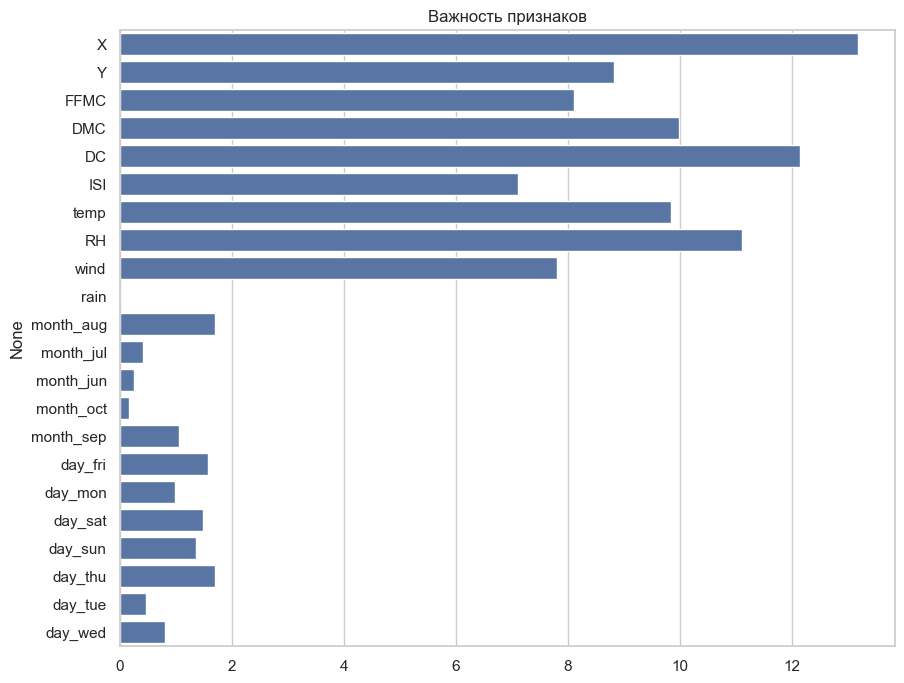

In [182]:
# Построение графика важности признаков
plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances, y=feature_names)
plt.title('Важность признаков')
plt.show()

In [185]:
# Удаление категориальных признаков с низкой важностью
X_class_reduced = X_class.drop(columns=['month_aug', 'month_jul', 'month_jun', 'month_oct', 'month_sep',
                                        'day_fri', 'day_mon', 'day_sat', 'day_sun', 'day_thu', 'day_tue', 'day_wed'])


In [186]:
# Функция для удаления выбросов с использованием межквартильного размаха (IQR)
def remove_outliers(data, columns):
    Q1 = data[columns].quantile(0.25)
    Q3 = data[columns].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[~((data[columns] < lower_bound) | (data[columns] > upper_bound)).any(axis=1)]

# Признаки для обработки выбросов
outlier_columns = ['Y', 'FFMC', 'DMC', 'ISI', 'RH', 'wind', 'rain']

# Удаление выбросов
X_class_cleaned = remove_outliers(X_class_reduced, outlier_columns)
y_class_cleaned = y_class[X_class_cleaned.index]

print(f"Размер данных до удаления выбросов: {X_class_reduced.shape}")
print(f"Размер данных после удаления выбросов: {X_class_cleaned.shape}")


Размер данных до удаления выбросов: (270, 10)
Размер данных после удаления выбросов: (235, 10)


In [191]:
# Разделение данных на тренировочный и тестовый наборы
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class_cleaned, y_class_cleaned, test_size=0.2, random_state=42)

In [188]:
# Обучение модели CatBoostClassifier
clf_cat = CatBoostClassifier(random_state=42, verbose=0)
clf_cat.fit(X_train_class, y_train_class)

In [190]:
# Предсказание на тестовых данных
y_pred_cat = clf_cat.predict(X_test_class)
y_pred_cat_proba = clf_cat.predict_proba(X_test_class)[:, 1]

In [192]:
# Оценка модели
print("CatBoost Classification Report:")
print(classification_report(y_test_class, y_pred_cat))
print("Accuracy:", accuracy_score(y_test_class, y_pred_cat))
print("Precision:", precision_score(y_test_class, y_pred_cat))
print("Recall:", recall_score(y_test_class, y_pred_cat))
print("F1 Score:", f1_score(y_test_class, y_pred_cat))
print("ROC AUC Score:", roc_auc_score(y_test_class, y_pred_cat_proba))

CatBoost Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.73      0.62        26
           1       0.42      0.24      0.30        21

    accuracy                           0.51        47
   macro avg       0.48      0.48      0.46        47
weighted avg       0.49      0.51      0.48        47

Accuracy: 0.5106382978723404
Precision: 0.4166666666666667
Recall: 0.23809523809523808
F1 Score: 0.30303030303030304
ROC AUC Score: 0.4725274725274725


In [194]:
# Балансировка классов с помощью SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_class, y_train_class)

# Обучение модели CatBoostClassifier на балансированных данных
clf_cat_balanced = CatBoostClassifier(iterations=300, depth=4, learning_rate=0.1, random_state=42, verbose=0)
clf_cat_balanced.fit(X_train_balanced, y_train_balanced)
y_pred_cat_balanced = clf_cat_balanced.predict(X_test_class)

print("CatBoost Classification Report (Balanced):")
print(classification_report(y_test_class, y_pred_cat_balanced))
print("Accuracy:", accuracy_score(y_test_class, y_pred_cat_balanced))
print("Precision:", precision_score(y_test_class, y_pred_cat_balanced))
print("Recall:", recall_score(y_test_class, y_pred_cat_balanced))
print("F1 Score:", f1_score(y_test_class, y_pred_cat_balanced))
print("ROC AUC Score:", roc_auc_score(y_test_class, y_pred_cat_balanced))

CatBoost Classification Report (Balanced):
              precision    recall  f1-score   support

           0       0.52      0.50      0.51        26
           1       0.41      0.43      0.42        21

    accuracy                           0.47        47
   macro avg       0.46      0.46      0.46        47
weighted avg       0.47      0.47      0.47        47

Accuracy: 0.46808510638297873
Precision: 0.4090909090909091
Recall: 0.42857142857142855
F1 Score: 0.4186046511627907
ROC AUC Score: 0.4642857142857143


In [195]:
# Определение сетки гиперпараметров
param_grid = {
    'iterations': [100, 200, 300, 500, 1000],
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5, 7, 9]
}

# Инициализация модели CatBoostClassifier
model_cat = CatBoostClassifier(random_state=42, verbose=0)

# Использование GridSearchCV для поиска лучших гиперпараметров
grid_search = GridSearchCV(estimator=model_cat, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_balanced, y_train_balanced)

# Получение лучших гиперпараметров
best_model_cat = grid_search.best_estimator_
y_pred_best_cat = best_model_cat.predict(X_test_class)
y_pred_best_cat_proba = best_model_cat.predict_proba(X_test_class)[:, 1]

# Оценка модели с лучшими гиперпараметрами
print("Best CatBoost Classification Report:")
print(classification_report(y_test_class, y_pred_best_cat))
print("Accuracy:", accuracy_score(y_test_class, y_pred_best_cat))
print("Precision:", precision_score(y_test_class, y_pred_best_cat))
print("Recall:", recall_score(y_test_class, y_pred_best_cat))
print("F1 Score:", f1_score(y_test_class, y_pred_best_cat))
print("ROC AUC Score:", roc_auc_score(y_test_class, y_pred_best_cat_proba))
print("Лучшие гиперпараметры:", grid_search.best_params_)


Fitting 5 folds for each of 400 candidates, totalling 2000 fits
Best CatBoost Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.50      0.52        26
           1       0.43      0.48      0.45        21

    accuracy                           0.49        47
   macro avg       0.49      0.49      0.49        47
weighted avg       0.49      0.49      0.49        47

Accuracy: 0.48936170212765956
Precision: 0.43478260869565216
Recall: 0.47619047619047616
F1 Score: 0.45454545454545453
ROC AUC Score: 0.4706959706959707
Лучшие гиперпараметры: {'depth': 10, 'iterations': 100, 'l2_leaf_reg': 7, 'learning_rate': 0.1}


Попробуем решить чере кластерезацию

In [197]:
data_encoded_cleaned = pd.get_dummies(data_cleaned, columns=['month', 'day'])
scaler = StandardScaler()
numerical_features = ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']
data_encoded_cleaned[numerical_features] = scaler.fit_transform(data_encoded_cleaned[numerical_features])

In [205]:
# Кластеризация с использованием KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
data_encoded_cleaned['cluster'] = kmeans.fit_predict(data_encoded_cleaned)

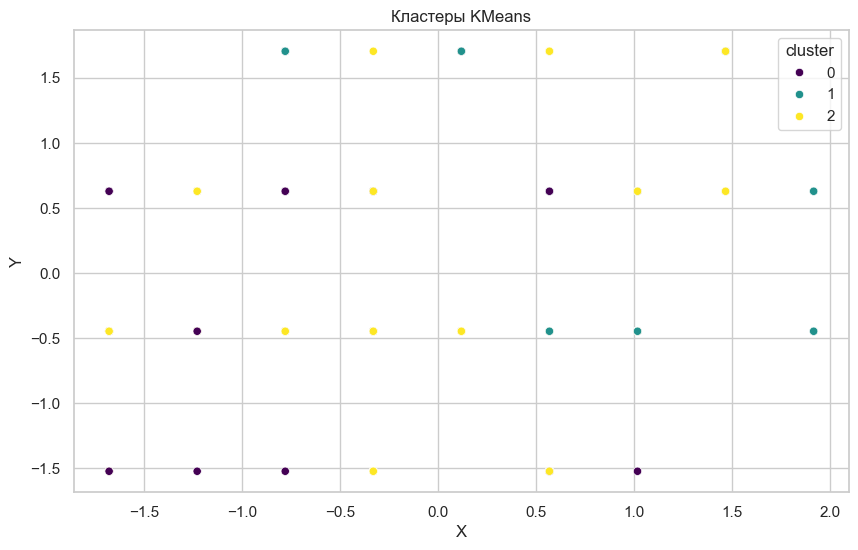

In [206]:
# Визуализация кластеров
plt.figure(figsize=(10, 6))
sns.scatterplot(x='X', y='Y', hue='cluster', data=data_encoded_cleaned, palette='viridis')
plt.title('Кластеры KMeans')
plt.show()

In [207]:
# Анализ кластеров
print(data_encoded_cleaned['cluster'].value_counts())

cluster
0    128
2     91
1     51
Name: count, dtype: int64
